Generating waveform plot for chirp_out.wav...


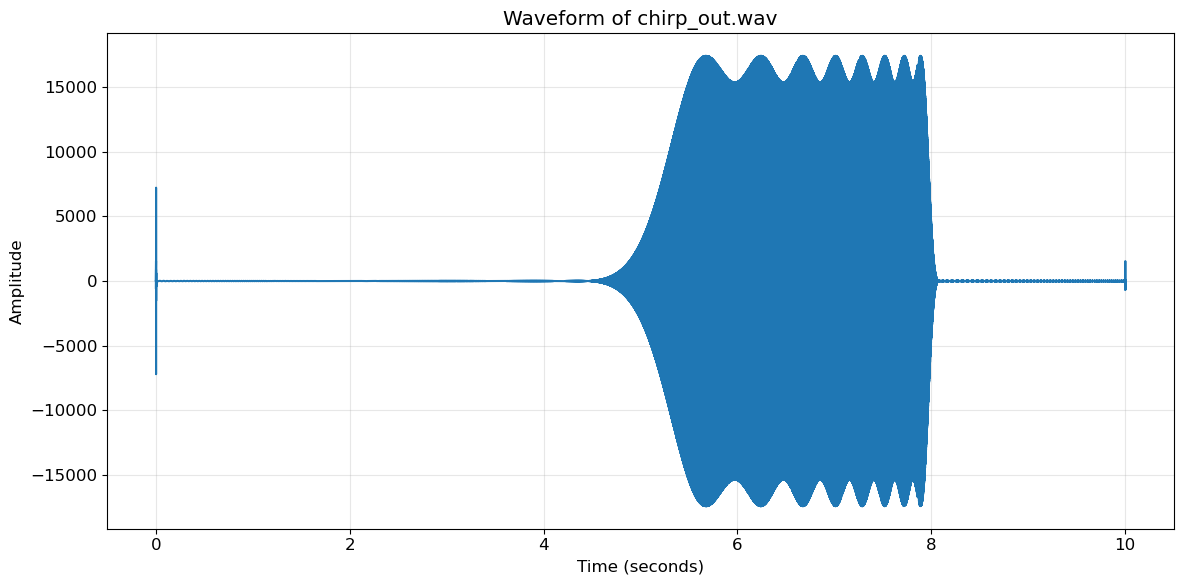

Generating spectrogram for chirp_out.wav...


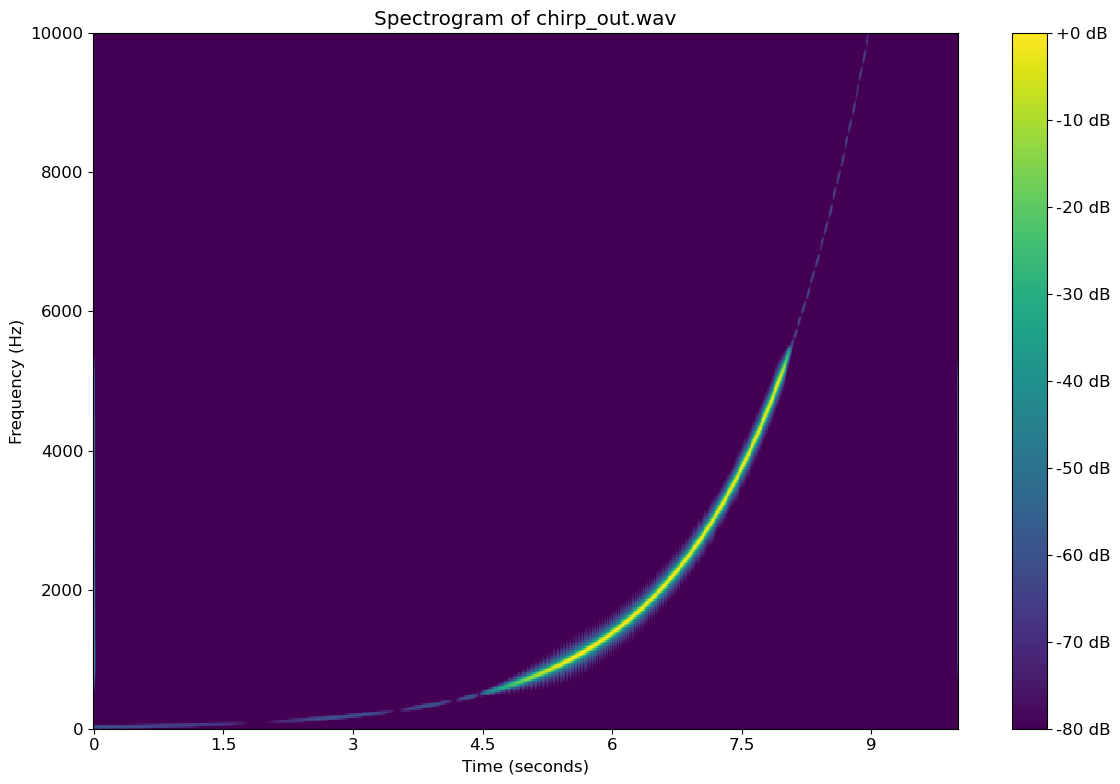

Generating magnitude spectrum for noise_out.wav...


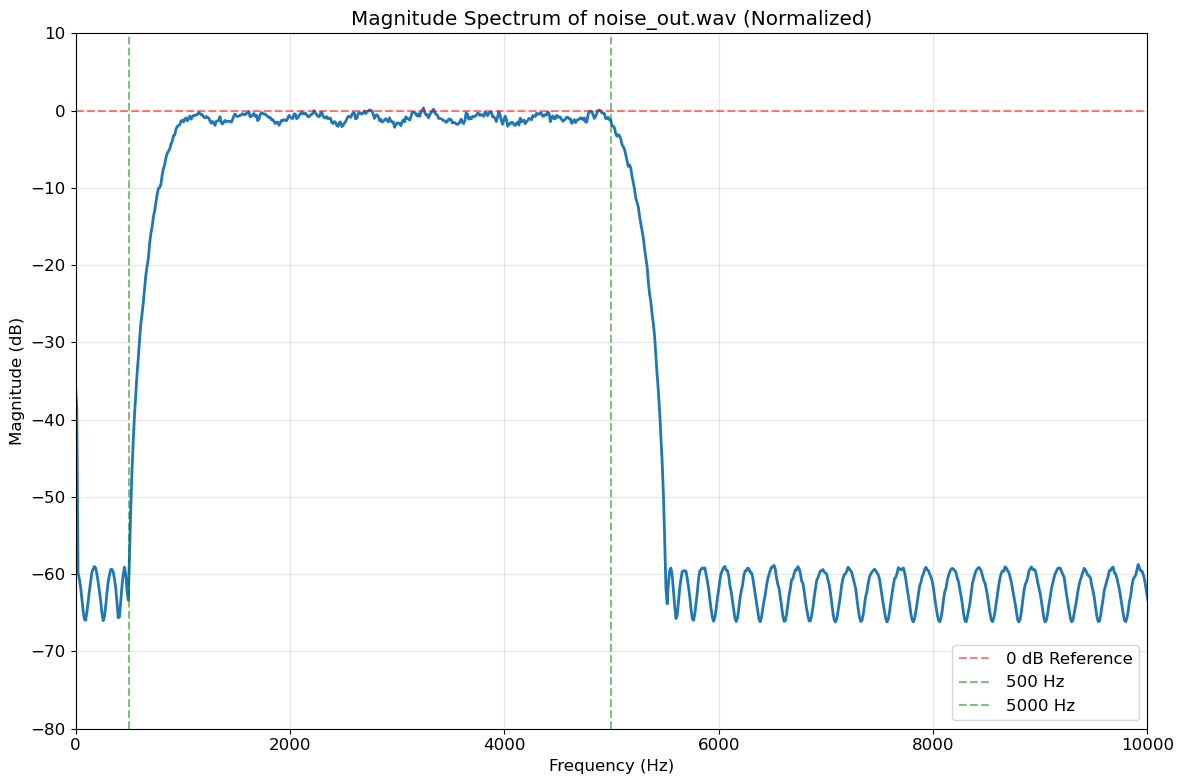

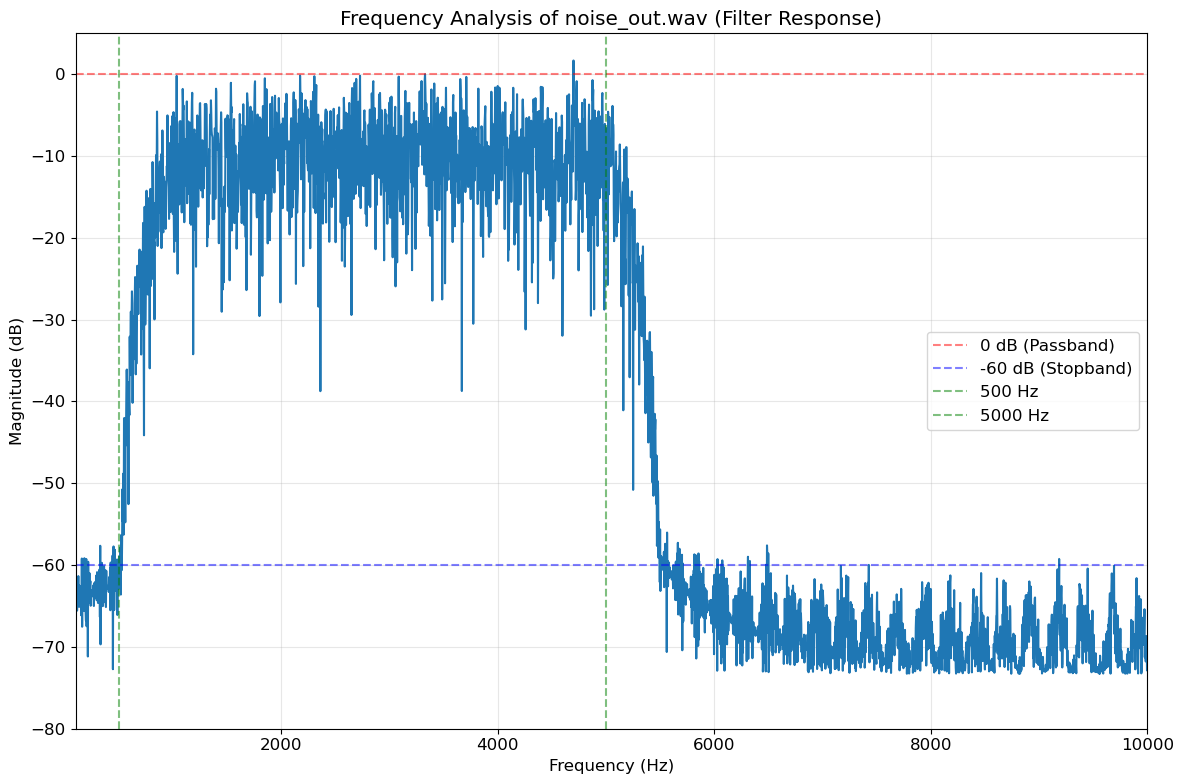

All plots saved to plots/ directory
Generated files:
  - plots/chirp_waveform.png
  - plots/chirp_spectrogram.png
  - plots/noise_spectrum.png
  - plots/noise_spectrum_filter_response.png


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import librosa
import librosa.display

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Create output directory for plots
import os
plot_dir = "plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# 1. Plot waveform of chirp_out.wav
print("Generating waveform plot for chirp_out.wav...")
sample_rate, chirp_data = wavfile.read('chirp_out.wav')
time = np.arange(len(chirp_data)) / sample_rate

plt.figure(figsize=(12, 6))
plt.plot(time, chirp_data)
plt.title('Waveform of chirp_out.wav')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{plot_dir}/chirp_waveform.png', dpi=300)
plt.show()

# 2. Plot spectrogram of chirp_out.wav
print("Generating spectrogram for chirp_out.wav...")
plt.figure(figsize=(12, 8))

# Load audio using librosa for better spectrogram display
chirp_audio, sr = librosa.load('chirp_out.wav', sr=None)

# Create spectrogram
D = librosa.stft(chirp_audio, n_fft=2048, hop_length=512)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Display spectrogram
img = librosa.display.specshow(S_db, 
                               sr=sr, 
                               x_axis='time', 
                               y_axis='linear',
                               hop_length=512,
                               cmap='viridis')
plt.colorbar(img, format='%+2.0f dB')
plt.title('Spectrogram of chirp_out.wav')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0, 10000)  # Focus on 0-10kHz range as per the PDF
plt.tight_layout()
plt.savefig(f'{plot_dir}/chirp_spectrogram.png', dpi=300)
plt.show()

# 3. Plot magnitude spectrum of noise_out.wav
print("Generating magnitude spectrum for noise_out.wav...")
sample_rate, noise_data = wavfile.read('noise_out.wav')

# Convert to float and normalize
if noise_data.dtype == np.int16:
    noise_data = noise_data.astype(float) / 32768.0
elif noise_data.dtype == np.int32:
    noise_data = noise_data.astype(float) / 2147483648.0
else:
    noise_data = noise_data.astype(float)

# Use Welch's method for better spectrum estimation
frequencies, power_spectrum = signal.welch(noise_data, 
                                          fs=sample_rate, 
                                          nperseg=4096,
                                          scaling='density')

# Convert to dB, avoiding log(0)
power_db = 10 * np.log10(power_spectrum + 1e-12)

# Find reference level at passband center (around 2750 Hz)
passband_center_idx = np.argmin(np.abs(frequencies - 2750))
reference_level = power_db[passband_center_idx]

# Normalize to reference level
power_db_normalized = power_db - reference_level

plt.figure(figsize=(12, 8))
plt.plot(frequencies, power_db_normalized, linewidth=2)
plt.title('Magnitude Spectrum of noise_out.wav (Normalized)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xlim(0, 10000)  # Focus on 0-10kHz
plt.ylim(-80, 10)   # Adjusted range
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='0 dB Reference')
plt.axvline(x=500, color='g', linestyle='--', alpha=0.5, label='500 Hz')
plt.axvline(x=5000, color='g', linestyle='--', alpha=0.5, label='5000 Hz')
plt.legend()
plt.tight_layout()
plt.savefig(f'{plot_dir}/noise_spectrum.png', dpi=300)
plt.show()

# Alternative frequency analysis method (matching the PDF style)
plt.figure(figsize=(12, 8))

# Use FFT for a cleaner view of the filter response
sample_rate, noise_data = wavfile.read('noise_out.wav')

# Convert to float and normalize properly
if noise_data.dtype == np.int16:
    noise_data = noise_data.astype(float) / 32768.0
elif noise_data.dtype == np.int32:
    noise_data = noise_data.astype(float) / 2147483648.0

# Compute PSD using periodogram (gives cleaner view of filter shape)
f, Pxx = signal.periodogram(noise_data, fs=sample_rate, window='hamming', nfft=16384)

# Convert to dB
Pxx_db = 10 * np.log10(Pxx + 1e-12)

# Find the passband peak for normalization
passband_mask = (f > 1000) & (f < 4000)
passband_max = np.max(Pxx_db[passband_mask])

# Normalize to passband peak
Pxx_db_normalized = Pxx_db - passband_max

plt.plot(f, Pxx_db_normalized, linewidth=1.5)
plt.title('Frequency Analysis of noise_out.wav (Filter Response)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xlim(100, 10000)  # Focus on the filter range
plt.ylim(-80, 5)     # Show -80dB to +5dB
plt.grid(True, alpha=0.3, which='both')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='0 dB (Passband)')
plt.axhline(y=-60, color='b', linestyle='--', alpha=0.5, label='-60 dB (Stopband)')
plt.axvline(x=500, color='g', linestyle='--', alpha=0.5, label='500 Hz')
plt.axvline(x=5000, color='g', linestyle='--', alpha=0.5, label='5000 Hz')
plt.legend()
plt.tight_layout()
plt.savefig(f'{plot_dir}/noise_spectrum_filter_response.png', dpi=300)
plt.show()

print(f"All plots saved to {plot_dir}/ directory")
print("Generated files:")
print(f"  - {plot_dir}/chirp_waveform.png")
print(f"  - {plot_dir}/chirp_spectrogram.png")
print(f"  - {plot_dir}/noise_spectrum.png")
print(f"  - {plot_dir}/noise_spectrum_filter_response.png")